## **프로젝트 : 네이버 영화리뷰 감성분석 도전하기**

### **1) 데이터 준비와 확인**

In [1]:
# 필요한 라이브러리 import
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.initializers import Constant
from konlpy.tag import Mecab
from collections import Counter
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors

In [2]:
# 데이터 불러오기 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### **2) 데이터로더 구성**
* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전 word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
# 한국어 토크나이저로 Mecab을 사용
tokenizer = Mecab()

# 불용어(stopwords)로 사용할 단어들을 리스트로 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [4]:
def load_data(train_data, test_data, num_words=10000):
    # 데이터의 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    
    # NaN 결측치 제거
    train_data.dropna(subset=['document'], inplace=True)
    test_data.dropna(subset=['document'], inplace=True)
    
    X_train = []
    for sentence in train_data['document']:
        # 한국어 토크나이저로 토큰화
        temp_X = tokenizer.morphs(sentence)
        # 불용어(Stopwords) 제거
        temp_X = [word for word in temp_X if word not in stopwords]
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        # 한국어 토크나이저로 토큰화
        temp_X = tokenizer.morphs(sentence)
        # 불용어(Stopwords) 제거
        temp_X = [word for word in temp_X if word not in stopwords]
        X_test.append(temp_X)
    
    # 사전 word_to_index 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # 텍스트 스트링을 사전 인덱스 스트링으로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    y_train = np.array(list(train_data['label']))
    y_test = np.array(list(test_data['label']))
    
    # X_train, y_train, X_test, y_test, word_to_index 리턴
    return X_train, y_train, X_test, y_test, word_to_index

In [5]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [6]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [7]:
# 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [8]:
# encode된 텍스트 확인
X_train[0]

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]

In [9]:
# decode 되는지 확인
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


### **3) 모델 구성을 위한 데이터 분석 및 가공**
* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [10]:
# 모든 문장을 하나로 합치기
total_data_text = list(X_train) + list(X_test)

# 텍스트 문장의 길이 리스트 생성
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

# 문장 길이의 평균, 최대값, 표준편차 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 최대 길이를 (평균 + 2 * 표준편차)로 설정
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)

# 전체 문장 중 maxlen 설정값 이내에 포함된 비율 계산
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [11]:
# 패딩 추가
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

In [12]:
print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


RNN 모델에서 마지막 입력은 최종 상태에 가장 큰 영향을 미치므로, 무의미한 패딩을 사용하여 마지막 입력을 채우는 것은 비효율적이다.  
따라서, 패딩을 적용할 때는 pre 방식을 사용하는 것이 좋다.

### **4) 모델 구성 및 validation set 구성**

In [13]:
# 모델 구성
vocab_size = 10000 # 어휘 사전의 크기
word_vector_dim = 100 # 단어 하나를 표현하는 임베딩 벡터의 차원수

# LSTM
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.LSTM(64))
model_lstm.add(tf.keras.layers.Dense(32, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,044,353
Trainable params: 1,044,353
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Bidirectional LSTM
model_bi_lstm = tf.keras.Sequential()
model_bi_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_bi_lstm.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model_bi_lstm.add(tf.keras.layers.Dense(32, activation='relu'))
model_bi_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_bi_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,088,641
Trainable params: 1,088,641
Non-trainable params: 0
_________________________________________________________________


In [15]:
# 1-D CNN
model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(tf.keras.layers.Conv1D(64, 5, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_cnn.add(tf.keras.layers.Conv1D(128, 5, activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(tf.keras.layers.Dense(32, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         41088     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [16]:
# GlobalMaxPooling1D
model_pooling = tf.keras.Sequential()
model_pooling.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_pooling.add(tf.keras.layers.GlobalMaxPooling1D())
model_pooling.add(tf.keras.layers.Dense(32, activation='relu'))
model_pooling.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_pooling.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 1,003,265
Trainable params: 1,003,265
Non-trainable params: 0
_________________________________________________________________


모델 훈련 전에, 훈련용 데이터셋 146182건 중 43000건(약 30%)을 분리하여 검증셋으로 사용하도록 한다.

In [17]:
# validation set 구성
# validation set 30000건 분리
X_val = X_train[:43000]   
y_val = y_train[:43000]

# validation set을 제외한 나머지
partial_X_train = X_train[43000:]
partial_y_train = y_train[43000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(103182, 41)
(103182,)


### **5) 모델 훈련 개시**

In [18]:
# 모델을 컴파일하고 훈련하는 함수
def train_model(model):
    # 모델 컴파일
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # 모델 훈련
    history = model.fit(partial_X_train,
                        partial_y_train,
                        epochs=5,
                        batch_size=64,
                        validation_data=(X_val, y_val),
                        verbose=1)
    
    return history

In [19]:
# 각 모델에 대해 훈련
history_lstm = train_model(model_lstm)
history_bi_lstm = train_model(model_bi_lstm)
history_cnn = train_model(model_cnn)
history_pooling = train_model(model_pooling)

Epoch 1/5
1613/1613 [==============================] - 13s 6ms/step - loss: 0.3802 - accuracy: 0.8278 - val_loss: 0.3365 - val_accuracy: 0.8553
Epoch 2/5
1613/1613 [==============================] - 9s 6ms/step - loss: 0.2890 - accuracy: 0.8767 - val_loss: 0.3159 - val_accuracy: 0.8651
Epoch 3/5
1613/1613 [==============================] - 9s 6ms/step - loss: 0.2422 - accuracy: 0.8989 - val_loss: 0.3361 - val_accuracy: 0.8635
Epoch 4/5
1613/1613 [==============================] - 9s 6ms/step - loss: 0.2044 - accuracy: 0.9160 - val_loss: 0.3629 - val_accuracy: 0.8586
Epoch 5/5
1613/1613 [==============================] - 9s 6ms/step - loss: 0.1717 - accuracy: 0.9309 - val_loss: 0.4202 - val_accuracy: 0.8556
Epoch 1/5
1613/1613 [==============================] - 16s 9ms/step - loss: 0.3816 - accuracy: 0.8277 - val_loss: 0.3357 - val_accuracy: 0.8561
Epoch 2/5
1613/1613 [==============================] - 13s 8ms/step - loss: 0.2906 - accuracy: 0.8762 - val_loss: 0.3146 - val_accuracy: 0.8

In [20]:
# 각 모델에 대한 테스트 데이터 평가
results = {
    'LSTM': model_lstm.evaluate(X_test, y_test, verbose=2),
    'Bi-LSTM': model_bi_lstm.evaluate(X_test, y_test, verbose=2),
    'CNN': model_cnn.evaluate(X_test, y_test, verbose=2),
    'Pooling': model_pooling.evaluate(X_test, y_test, verbose=2)
}

for model_name, result in results.items():
    print(f'{model_name} - Loss: {result[0]}, Accuracy: {result[1]}')

1537/1537 - 3s - loss: 0.4252 - accuracy: 0.8528
1537/1537 - 4s - loss: 0.4401 - accuracy: 0.8457
1537/1537 - 3s - loss: 0.6645 - accuracy: 0.8097
1537/1537 - 2s - loss: 0.4530 - accuracy: 0.8380
LSTM - Loss: 0.42518144845962524, Accuracy: 0.8527981638908386
Bi-LSTM - Loss: 0.4401087462902069, Accuracy: 0.8456577658653259
CNN - Loss: 0.6644769906997681, Accuracy: 0.809711754322052
Pooling - Loss: 0.4530460238456726, Accuracy: 0.8379681706428528


### **6) Loss, Accuracy 그래프 시각화**

In [21]:
# 손실과 정확도 그래프 출력하는 함수
def plot_history(history, model_name):
    # 손실과 정확도 값 추출
    history_dict = history.history
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    # 손실 그래프
    plt.plot(epochs, loss, 'bo', label=f'{model_name} - Training loss')
    plt.plot(epochs, val_loss, 'b', label=f'{model_name} - Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    plt.clf() # 그림 초기화
    
    # 정확도 그래프
    plt.plot(epochs, acc, 'bo', label=f'{model_name} - Training acc')
    plt.plot(epochs, val_acc, 'b', label=f'{model_name} - Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

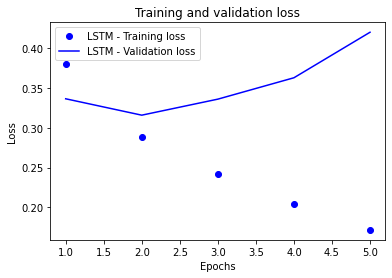

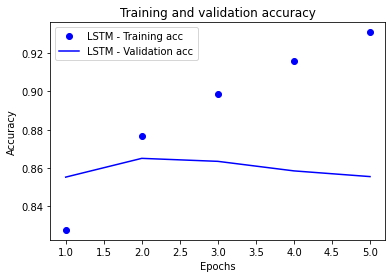

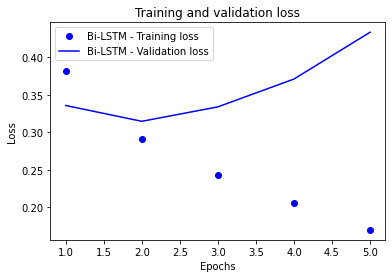

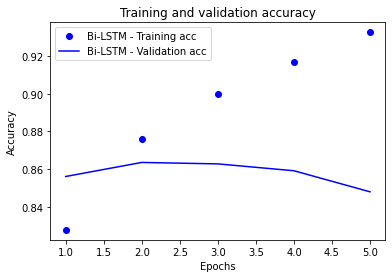

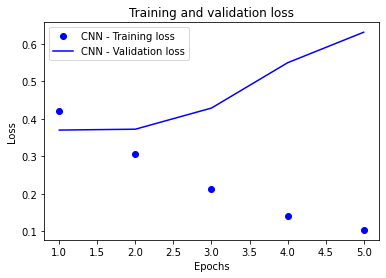

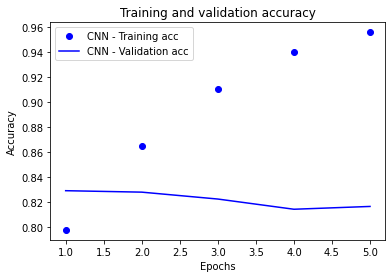

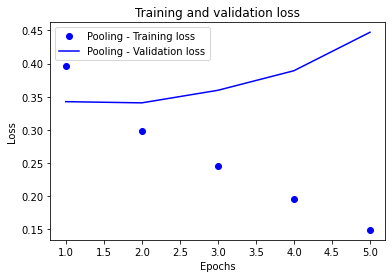

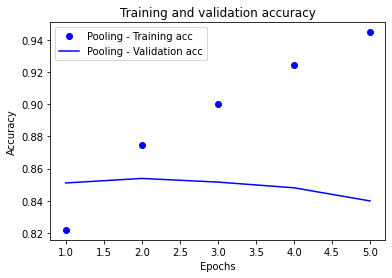

In [22]:
# 각 모델에 대해 그래프 출력
plot_history(history_lstm, 'LSTM')
plot_history(history_bi_lstm, 'Bi-LSTM')
plot_history(history_cnn, 'CNN')
plot_history(history_pooling, 'Pooling')

### **7) 학습된 Embedding 레이어 분석**

In [23]:
embedding_layer = model_lstm.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 100)


In [24]:
# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

# 단어 개수(특수문자 4개는 제외)만큼의 워드 벡터를 파일에 기록 
vectors = model_lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [25]:
# word vector로 활용
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([ 0.14258018, -0.06739647, -0.06109495,  0.04527744, -0.03055697,
        0.20487888,  0.07879317,  0.01028523,  0.0701339 ,  0.2148662 ,
        0.06823857, -0.07191527, -0.14074819,  0.09312225,  0.03533353,
        0.03302068, -0.03197274, -0.05571914,  0.11153385, -0.30520836,
        0.08763205, -0.10189131,  0.11551742, -0.08647034,  0.01675555,
        0.12061619,  0.19054145, -0.03049414, -0.1457128 ,  0.00823453,
       -0.04979268, -0.06307099,  0.03661949, -0.1128941 ,  0.11008248,
        0.11132365, -0.01870122, -0.09199438, -0.03766695,  0.02359881,
        0.00782452,  0.00444456, -0.02733609, -0.00150432,  0.18856794,
       -0.04679576, -0.13766156, -0.10287365, -0.16725913, -0.07058994,
        0.08246616,  0.03677234,  0.05857552,  0.01874924, -0.06069599,
        0.07095737,  0.07444959,  0.10355474, -0.03383831,  0.1413103 ,
        0.15063722, -0.12500307, -0.00606704,  0.01449187, -0.06661329,
        0.11578311,  0.14023736, -0.03648367, -0.06454076,  0.00

In [26]:
# 워드 벡터가 의미 벡터 공간상에 유의미하게 학습되었는지 확인
word_vectors.similar_by_word("사랑")

[('푹', 0.8965718746185303),
 ('엘리트', 0.8944181799888611),
 ('시네마', 0.8852003812789917),
 ('베스트셀러', 0.884052574634552),
 ('빠져드', 0.8835819363594055),
 ('괜춘', 0.8829672336578369),
 ('씁시다', 0.8827657699584961),
 ('큐', 0.8784923553466797),
 ('소주', 0.878038763999939),
 ('디테일', 0.8771759271621704)]

In [27]:
word_vectors.similar_by_word("분노")

[('다는데', 0.8317752480506897),
 ('의심', 0.809384822845459),
 ('살짝', 0.8088809847831726),
 ('보단', 0.8011151552200317),
 ('구도', 0.7982693314552307),
 ('디지', 0.7906394004821777),
 ('어려', 0.7879568934440613),
 ('데스', 0.7861127853393555),
 ('따먹', 0.7745283842086792),
 ('거참', 0.7737649083137512)]

In [28]:
word_vectors.similar_by_word("바다")

[('그러', 0.7882046699523926),
 ('미모', 0.7881696820259094),
 ('애쓰', 0.7849180698394775),
 ('김수미', 0.7815319895744324),
 ('위선', 0.7765912413597107),
 ('진다는', 0.7681612968444824),
 ('적당히', 0.7573620080947876),
 ('따위', 0.7556273341178894),
 ('싸웠', 0.7529001832008362),
 ('쓸모없', 0.7523263692855835)]

유사한 다른 단어를 그리 잘 찾았다고 느껴지지는 않는다.

### **8) 한국어 Word2Vec 임베딩 활용하여 성능 개선**

In [29]:
word2vec_path = os.getenv('HOME') + '/data/word2vec_ko.model'
word2vec = Word2VecKeyedVectors.load(word2vec_path)
vector = word2vec.wv['컴퓨터']

print(vector.shape)
vector # 100dim의 워드 벡터

(100,)


array([-0.35898918, -3.7382367 , -1.1435223 , -0.2520832 , -2.421575  ,
        1.675243  ,  0.12040154,  0.30027202, -0.10066335, -1.852855  ,
       -1.5231812 ,  4.249661  , -2.0461752 , -1.8994397 ,  1.9720789 ,
        2.2885437 ,  0.37752038, -0.37131143,  1.5192999 , -3.986562  ,
        1.5290304 , -1.1876138 , -4.3212905 ,  0.60457045, -0.1556344 ,
       -0.8781025 ,  3.1387296 , -0.5732489 ,  2.6950948 ,  2.43627   ,
       -1.803436  ,  1.191884  , -1.9603088 ,  1.97387   , -0.05861414,
       -1.2503568 ,  1.649908  , -1.9944221 , -0.04815336, -0.45580134,
        2.1869504 , -3.3291643 ,  1.1504062 ,  0.96880984, -1.1941013 ,
        2.685823  ,  1.5262356 ,  0.13755637,  3.1111014 ,  0.23526062,
        0.36584985,  0.36928275, -0.5305036 , -3.5831432 ,  2.6298168 ,
       -0.65791756,  4.177953  , -2.858328  , -0.22881825,  0.34941065,
        0.12948069,  5.346858  ,  2.2717035 ,  0.06239161,  0.01912611,
       -2.8868406 , -2.9170113 ,  0.11012372, -0.24658982,  0.66

In [30]:
word2vec.wv.similar_by_word("사랑")

[('이별', 0.7626414895057678),
 ('행복', 0.7550068497657776),
 ('슬픔', 0.7381505966186523),
 ('유혹', 0.7238055467605591),
 ('그리움', 0.7167419195175171),
 ('추억', 0.7143999338150024),
 ('꿈', 0.7089294195175171),
 ('애정', 0.7066588997840881),
 ('포옹', 0.7034594416618347),
 ('마음', 0.6972615718841553)]

In [31]:
word2vec.wv.similar_by_word("분노")

[('증오', 0.7812762260437012),
 ('당황', 0.7669417262077332),
 ('질투', 0.7653574347496033),
 ('격분', 0.7615478038787842),
 ('분개', 0.7558894157409668),
 ('격노', 0.744964599609375),
 ('배신', 0.7379286885261536),
 ('원망', 0.7247334718704224),
 ('실망', 0.7243136763572693),
 ('배반', 0.7084240317344666)]

In [32]:
word2vec.wv.similar_by_word("바다")

[('육지', 0.810200572013855),
 ('바닷가', 0.7969527244567871),
 ('골짜기', 0.7926910519599915),
 ('모래', 0.7809723615646362),
 ('파도', 0.7670643329620361),
 ('절벽', 0.7651501893997192),
 ('바위', 0.7584086060523987),
 ('바닷속', 0.7550424933433533),
 ('하늘', 0.7468580007553101),
 ('해안가', 0.7398057579994202)]

Word2Vec에서 제공하는 워드 임베딩 벡터들끼리는 의미적 유사도가 가까운 것이 서로 가깝게 제대로 학습된 것을 확인할 수 있다.  

이제 이전 스텝에서 학습했던 모델의 임베딩 레이어를 Word2Vec의 것으로 교체하여 다시 학습시켜보자.

In [33]:
# 임베딩 행렬 초기화
vocab_size = 10000 # 어휘 사전의 크기
word_vector_dim = 100 # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피
for i in range(4, vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [34]:
# LSTM
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix), # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True)) # trainable을 True로 주면 Fine-tuning
model_lstm.add(tf.keras.layers.LSTM(64))
model_lstm.add(tf.keras.layers.Dense(32, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 1,044,353
Trainable params: 1,044,353
Non-trainable params: 0
_________________________________________________________________


In [35]:
# Bidirectional LSTM
model_bi_lstm = tf.keras.Sequential()
model_bi_lstm.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
model_bi_lstm.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model_bi_lstm.add(tf.keras.layers.Dense(32, activation='relu'))
model_bi_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_bi_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 1,088,641
Trainable params: 1,088,641
Non-trainable params: 0
_________________________________________________________________


In [36]:
# 1-D CNN
model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
model_cnn.add(tf.keras.layers.Conv1D(64, 5, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_cnn.add(tf.keras.layers.Conv1D(128, 5, activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(tf.keras.layers.Dense(32, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model_cnn.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 37, 64)            32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 64)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3, 128)            41088     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

In [37]:
# GlobalMaxPooling1D
model_pooling = tf.keras.Sequential()
model_pooling.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
model_pooling.add(tf.keras.layers.GlobalMaxPooling1D())
model_pooling.add(tf.keras.layers.Dense(32, activation='relu'))
model_pooling.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_pooling.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 32)                3232      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 1,003,265
Trainable params: 1,003,265
Non-trainable params: 0
_________________________________________________________________


In [38]:
# 각 모델에 대해 훈련
history_lstm = train_model(model_lstm)
history_bi_lstm = train_model(model_bi_lstm)
history_cnn = train_model(model_cnn)
history_pooling = train_model(model_pooling)

Epoch 1/5
1613/1613 [==============================] - 11s 6ms/step - loss: 0.4296 - accuracy: 0.7980 - val_loss: 0.3580 - val_accuracy: 0.8425
Epoch 2/5
1613/1613 [==============================] - 9s 6ms/step - loss: 0.3209 - accuracy: 0.8609 - val_loss: 0.3346 - val_accuracy: 0.8538
Epoch 3/5
1613/1613 [==============================] - 9s 6ms/step - loss: 0.2791 - accuracy: 0.8812 - val_loss: 0.3291 - val_accuracy: 0.8587
Epoch 4/5
1613/1613 [==============================] - 9s 6ms/step - loss: 0.2491 - accuracy: 0.8962 - val_loss: 0.3338 - val_accuracy: 0.8590
Epoch 5/5
1613/1613 [==============================] - 9s 6ms/step - loss: 0.2203 - accuracy: 0.9097 - val_loss: 0.3520 - val_accuracy: 0.8576
Epoch 1/5
1613/1613 [==============================] - 16s 9ms/step - loss: 0.4285 - accuracy: 0.7988 - val_loss: 0.3538 - val_accuracy: 0.8445
Epoch 2/5
1613/1613 [==============================] - 13s 8ms/step - loss: 0.3173 - accuracy: 0.8626 - val_loss: 0.3320 - val_accuracy: 0.8

In [39]:
# 각 모델에 대한 테스트 데이터 평가
results = {
    'LSTM': model_lstm.evaluate(X_test, y_test, verbose=2),
    'Bi-LSTM': model_bi_lstm.evaluate(X_test, y_test, verbose=2),
    'CNN': model_cnn.evaluate(X_test, y_test, verbose=2),
    'Pooling': model_pooling.evaluate(X_test, y_test, verbose=2)
}

for model_name, result in results.items():
    print(f'{model_name} - Loss: {result[0]}, Accuracy: {result[1]}')

1537/1537 - 3s - loss: 0.3574 - accuracy: 0.8550
1537/1537 - 4s - loss: 0.3545 - accuracy: 0.8552
1537/1537 - 3s - loss: 0.4158 - accuracy: 0.8155
1537/1537 - 2s - loss: 0.4637 - accuracy: 0.7780
LSTM - Loss: 0.3574088513851166, Accuracy: 0.8550155758857727
Bi-LSTM - Loss: 0.35448357462882996, Accuracy: 0.8551782965660095
CNN - Loss: 0.415779173374176, Accuracy: 0.8155298233032227
Pooling - Loss: 0.4637141227722168, Accuracy: 0.7779970169067383


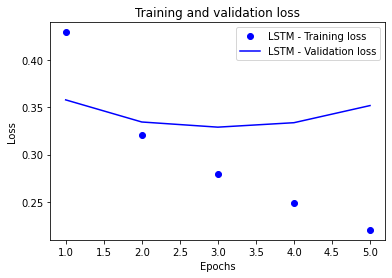

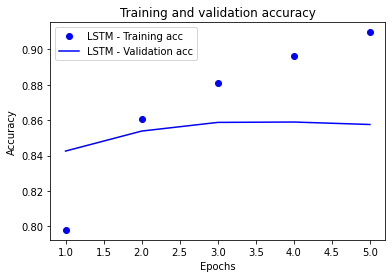

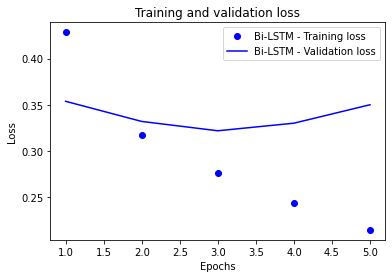

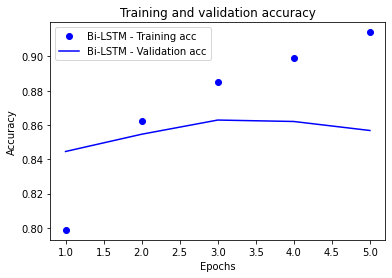

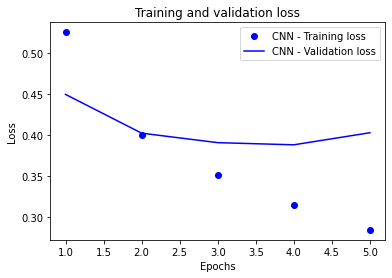

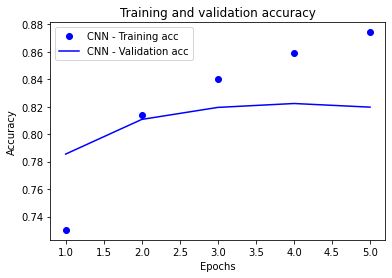

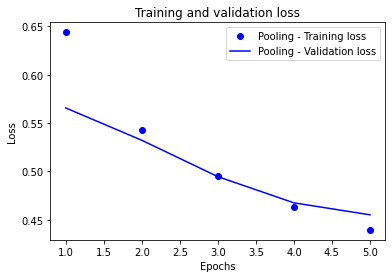

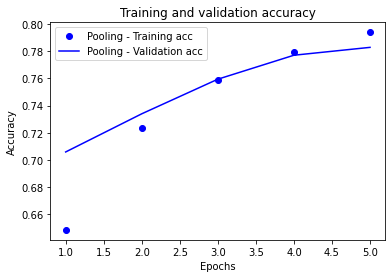

In [40]:
# 각 모델에 대해 그래프 출력
plot_history(history_lstm, 'LSTM')
plot_history(history_bi_lstm, 'Bi-LSTM')
plot_history(history_cnn, 'CNN')
plot_history(history_pooling, 'Pooling')

#### **Dropout 적용**

In [41]:
# LSTM with Dropout
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
model_lstm.add(tf.keras.layers.LSTM(64))
model_lstm.add(tf.keras.layers.Dropout(0.3))
model_lstm.add(tf.keras.layers.Dense(32, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_lstm.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 33        
Total params: 1,044,353
Trainable params: 1,044,353
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Bidirectional LSTM with Dropout
model_bi_lstm = tf.keras.Sequential()
model_bi_lstm.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
model_bi_lstm.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model_bi_lstm.add(tf.keras.layers.Dropout(0.3))
model_bi_lstm.add(tf.keras.layers.Dense(32, activation='relu'))
model_bi_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_bi_lstm.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               84480     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 1,088,641
Trainable params: 1,088,641
Non-trainable params: 0
_________________________________________________________________


In [43]:
# 1-D CNN with Dropout
model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
model_cnn.add(tf.keras.layers.Conv1D(64, 5, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_cnn.add(tf.keras.layers.Conv1D(128, 5, activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(tf.keras.layers.Dropout(0.3))
model_cnn.add(tf.keras.layers.Dense(32, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_cnn.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 37, 64)            32064     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 64)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 3, 128)            41088     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 32)              

In [44]:
# GlobalMaxPooling1D with Dropout
model_pooling = tf.keras.Sequential()
model_pooling.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
model_pooling.add(tf.keras.layers.GlobalMaxPooling1D())
model_pooling.add(tf.keras.layers.Dropout(0.3))
model_pooling.add(tf.keras.layers.Dense(32, activation='relu'))
model_pooling.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_pooling.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 41, 100)           1000000   
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 100)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)                3232      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 33        
Total params: 1,003,265
Trainable params: 1,003,265
Non-trainable params: 0
_________________________________________________________________


In [45]:
# 각 모델에 대해 훈련
history_lstm = train_model(model_lstm)
history_bi_lstm = train_model(model_bi_lstm)
history_cnn = train_model(model_cnn)
history_pooling = train_model(model_pooling)

Epoch 1/5
1613/1613 [==============================] - 12s 6ms/step - loss: 0.4476 - accuracy: 0.7885 - val_loss: 0.3562 - val_accuracy: 0.8434
Epoch 2/5
1613/1613 [==============================] - 10s 6ms/step - loss: 0.3365 - accuracy: 0.8535 - val_loss: 0.3447 - val_accuracy: 0.8492
Epoch 3/5
1613/1613 [==============================] - 10s 6ms/step - loss: 0.2984 - accuracy: 0.8737 - val_loss: 0.3174 - val_accuracy: 0.8623
Epoch 4/5
1613/1613 [==============================] - 10s 6ms/step - loss: 0.2715 - accuracy: 0.8865 - val_loss: 0.3284 - val_accuracy: 0.8606
Epoch 5/5
1613/1613 [==============================] - 10s 6ms/step - loss: 0.2487 - accuracy: 0.8979 - val_loss: 0.3369 - val_accuracy: 0.8591
Epoch 1/5
1613/1613 [==============================] - 17s 9ms/step - loss: 0.4437 - accuracy: 0.7898 - val_loss: 0.3566 - val_accuracy: 0.8434
Epoch 2/5
1613/1613 [==============================] - 14s 8ms/step - loss: 0.3327 - accuracy: 0.8564 - val_loss: 0.3301 - val_accuracy:

In [46]:
# 각 모델에 대한 테스트 데이터 평가
results = {
    'LSTM': model_lstm.evaluate(X_test, y_test, verbose=2),
    'Bi-LSTM': model_bi_lstm.evaluate(X_test, y_test, verbose=2),
    'CNN': model_cnn.evaluate(X_test, y_test, verbose=2),
    'Pooling': model_pooling.evaluate(X_test, y_test, verbose=2)
}

for model_name, result in results.items():
    print(f'{model_name} - Loss: {result[0]}, Accuracy: {result[1]}')

1537/1537 - 3s - loss: 0.3434 - accuracy: 0.8561
1537/1537 - 4s - loss: 0.3343 - accuracy: 0.8618
1537/1537 - 3s - loss: 0.4045 - accuracy: 0.8174
1537/1537 - 2s - loss: 0.4942 - accuracy: 0.7707
LSTM - Loss: 0.34338781237602234, Accuracy: 0.8561344146728516
Bi-LSTM - Loss: 0.33432772755622864, Accuracy: 0.861830472946167
CNN - Loss: 0.4045095145702362, Accuracy: 0.8173606991767883
Pooling - Loss: 0.49415159225463867, Accuracy: 0.7706735730171204


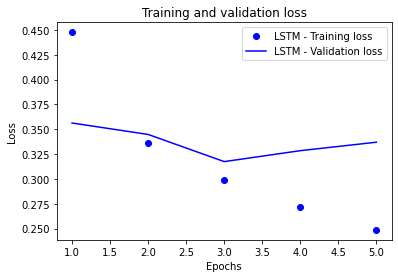

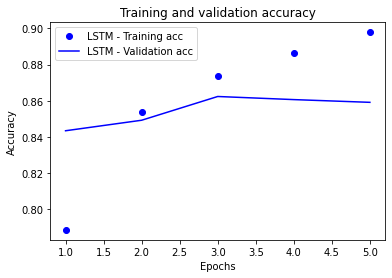

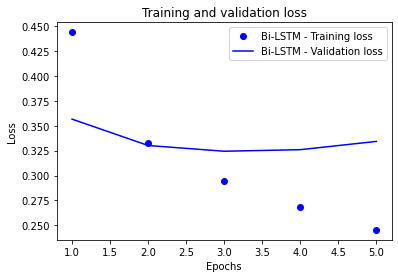

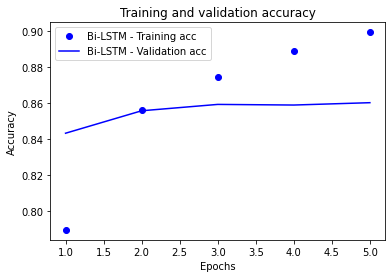

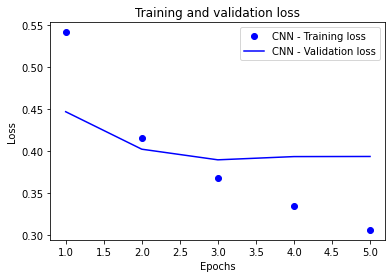

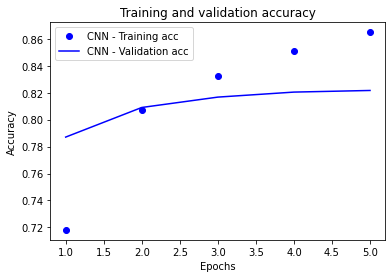

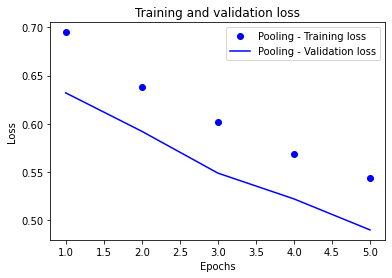

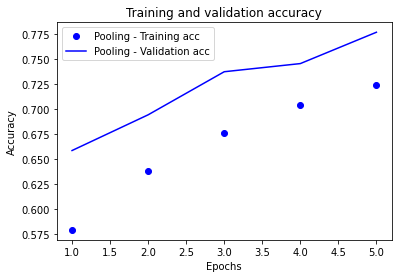

In [47]:
# 각 모델에 대해 그래프 출력
plot_history(history_lstm, 'LSTM')
plot_history(history_bi_lstm, 'Bi-LSTM')
plot_history(history_cnn, 'CNN')
plot_history(history_pooling, 'Pooling')

**모델 훈련 결과**

|Model|Loss|Accuracy(%)|
|------|---|---|
|LSTM|0.43|85.28|
|Bidirectional LSTM|0.44|84.57|
|1-D CNN|0.66|80.97|
|GlobalMaxPooling1D|0.45|83.80|

**한국어 Word2Vec 임베딩 활용 결과**

|Model|Loss|Accuracy(%)|
|------|---|---|
|LSTM|0.36|85.50|
|Bidirectional LSTM|0.35|85.52|
|1-D CNN|0.42|81.55|
|GlobalMaxPooling1D|0.46|77.80|

**Dropout 적용 결과**

|Model|Loss|Accuracy(%)|
|------|---|---|
|LSTM|0.34|85.61|
|Bidirectional LSTM|0.33|86.18|
|1-D CNN|0.40|81.74|
|GlobalMaxPooling1D|0.49|77.07|

1. 주어진 모델들의 정확도와 손실값은 큰 차이가 나타나지 않았다.
2. LSTM과 Bidirectional LSTM이 다른 모델들보다 상대적으로 높은 정확도를 보였다.
3. 한국어 Word2Vec 임베딩을 활용한 결과에서도 LSTM과 Bidirectional LSTM이 다른 모델들보다 높은 정확도를 보였다.
4. Dropout을 적용한 결과에서는 Bidirectional LSTM이 가장 높은 정확도를 보였다.

이러한 결과들을 종합적으로 고려할 때, Bidirectional LSTM이 다른 모델들보다 더 높은 정확도를 보이는 경향이 있으며, 한국어 Word2Vec 임베딩과 Dropout을 함께 적용할 때 가장 좋은 결과를 얻을 수 있을 것으로 보인다. (하지만 큰 차이는 없다 🥲)

---

### **프로젝트 회고**
이번 프로젝트를 하면서 가장 어려웠던 부분은 학습된 Embedding 레이어 분석과 한국어 Word2Vec 임베딩을 활용하여 성능을 개선하는 과정이었다. 코드 자체는 길지 않았지만, 코드가 정확히 어떤 일을 수행하고 왜 필요한지에 대한 이해가 온전히 이루어지지 않아 어려움이 있었던 것 같다. 이러한 어려움을 해결하기 위해 팀원과 함께 토론을 통해 코드의 에러를 해결하고 코드의 전반적인 흐름을 파악할 수 있게 되었다. 특히, 한국어 Word2Vec을 적용하는 과정에서 반복적으로 에러가 발생했는데, 나중에 알고보니 노드에 상세히 설명된 대로 .wv를 붙여서 활용해야 한다는 점을 놓치고 넘어갔던 것이었다. 정확한 지시사항을 읽고 .wv를 추가하면서 에러가 해결되었고, 코드가 원활히 작동하는 것을 확인할 수 있었다. NLP 프로젝트를 수행하면서 NLP 작업이 CV 작업보다 어렵다는 느낌을 받았는데, 두 작업 모두에서 용어 정리가 중요하다는 것을 깨달았으며, 코드의 세부 사항을 완벽히 이해하기는 어렵더라도 코드의 전반적인 흐름을 파악하고 넘어가는 것이 필요하다는 것을 더욱 더 느끼게 된 프로젝트였다.

**내가 시도해본 것**
1. 학습률: 0.001 추가
2. 모델 구조 변경: 더 많은 뉴런 및 다른 유닛 수 적용
3. Dropout 레이어 추가: 0.2에서 0.3으로 적용
4. 검증 데이터 분리: 20%에서 30%로 변경
5. batch_size 변경: 128에서 64로 변경
6. epoch 변경: 20에서 10으로, 그리고 10에서 5로 변경
7. word_vector_dim 변경: 16에서 100으로 변경
8. 다양한 모델 사용: LSTM, Bidirectional LSTM, 1-D CNN, GlobalMaxPooling1D

#### **새로 알게 된 것!**
* 임베딩(Embedding): 텍스트 데이터를 수치화하는 과정 중 하나로, 단어나 문장을 벡터로 변환하는 기법
* 1-D CNN: 텍스트 데이터에서 패턴을 추출하는 신경망 구조 중 하나로, 주로 텍스트 시퀀스 데이터에서 특징을 추출하는 데 사용
* GlobalMaxPooling1D(): 1-D 시퀀스 데이터에서 가장 중요한 특징을 추출하는 풀링 연산
* Word2Vec: 단어를 밀집 벡터로 표현하는 방법으로, 단어 간의 의미적 유사성을 포착하는 데 사용
* gensim: Python에서 자연어 처리를 위한 도구로, 토픽 모델링, 임베딩 등 다양한 기능을 제공하는 라이브러리

**State가 유지된다는 것의 의미**

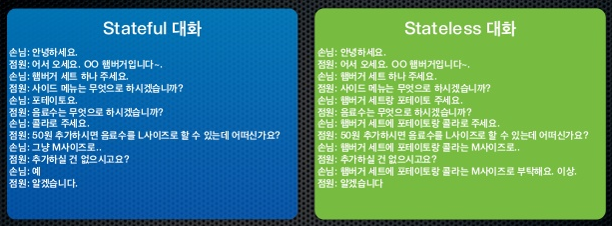

**텍스트 데이터만이 가지고 있는 정보적 특성과 가치는 어떤 것일까요?**  
텍스트 데이터는 사람들 간의 의사 소통, 지식 공유, 감정 표현 등을 담고 있어 사회적, 문화적, 심리적인 측면에서 다양한 정보를 제공한다.

**감성분석 등 텍스트 분류 모델이 다른 데이터 분석 업무에 어떤 점에서 도움을 주나요?**  
감성분석은 소셜 미디어 데이터에서 고객의 의견 파악이나 제품 평가 분석 등에 활용된다. 텍스트 분류 모델은 텍스트 데이터를 자동으로 분류하고 정리하여 대량의 데이터를 효율적으로 처리하고 정보를 추출하는 데 도움을 준다.

**텍스트 데이터 분석의 기술적 어려움은 무엇인가요?**  
텍스트 데이터는 비정형 데이터로써 다양한 문장 구조, 언어적 변이, 불완전한 문장 등의 특성을 가지고 있어 전처리 작업이 중요하다. 또한, 단어의 다의성, 문맥 의존성, 주관적인 표현 등을 처리하는 것도 도전적인 과제라고 볼 수 있다.

**텍스트 분류 작업을 하는데 딥러닝이 적용되면 어떤 점에서 유리해질까요?**  
딥러닝은 텍스트 분류 작업에서 특징을 자동으로 학습하고 복잡한 패턴을 인식할 수 있다. 이를 통해 다양한 텍스트 특성을 포착하고, 정확한 분류 성능을 높일 수 있다.

**참고한 레퍼런스**
<br>동아비즈니스리뷰 감성분석 활용 사례 기고 https://dbr.donga.com/article/view/1202/article_no/8891/ac/magazine
<br>김성훈 교수의 모두의 딥러닝 강좌 12강.RNN https://www.youtube.com/watch?v=-SHPG_KMUkQ&t=4s
<br>시퀀스 자료형과 RNN https://www.youtube.com/watch?t=1447&v=mG6N0ut9dog&feature=youtu.be
<br>자연어 처리를 위한 1D CNN(1D Convolutional Neural Networks) https://wikidocs.net/80437
<br>word2vec 이론 https://www.youtube.com/watch?v=sY4YyacSsLc&t=126s
<br>한국어 임베딩 서문 https://ratsgo.github.io/natural%20language%20processing/2019/09/12/embedding/
<br>Naver sentiment movie corpus https://github.com/e9t/nsmc
<br>네이버 영화 리뷰 감성 분류하기(Naver Movie Review Sentiment Analysis) https://wikidocs.net/44249